In [1]:
# taken from https://machinelearningmastery.com/how-to-load-and-explore-a-standard-human-activity-recognition-problem/
# and adapted for personal use

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Data description

The dataset “Activity Recognition from Single Chest-Mounted Accelerometer Data Set” was collected and made available by Casale, Pujol, et al. from the University of Barcelona in Spain.

The dataset is comprised of uncalibrated accelerometer data from 15 different subjects, each performing 7 activities. Each subject wore a custom-developed chest-mounted accelerometer and data was collected at 52Hz (52 observations per second).


The specific activities performed were:

1. Working at computer
2. Standing up, walking and going up/down stairs (not used in paper)
3. Standing
4. Walking
5. Going up/down stairs
6. Walking and talking with someone (not used in paper)
7. Talking while standing

The directory contains a list of CSV files, one per subject (1-15) and a readme file.

Each file contains 5 columns, the row number, x, y, and z accelerometer readings and a class number from 0 to 7, where class 0 means “no activity” and classes 1-7 correspond to the activities listed in the previous section.

## Load dataset

In [3]:
collection_rate = 52.  # Hz
def load_dataset(path="HAR-data"):
    datasets = []
    for name in os.listdir(path):
        filename = os.path.join(path, name)
        if not filename.endswith(".csv"):
            continue
        df = pd.read_csv(filename, names=["idx", "X", "Y", "Z", "activity"]).drop("idx", axis=1)
        df["person"] = name.split(".")[0]
        datasets.append(df)  
    
    return pd.concat(datasets, ignore_index=False)
 
dataset = load_dataset()
dataset

,X,Y,Z,activity,person
0,1502,2215,2153,1,1
1,1667,2072,2047,1,1
2,1611,1957,1906,1,1
3,1601,1939,1831,1,1
4,1643,1965,1879,1,1
...,...,...,...,...,...
166736,2072,2545,2059,7,9
166737,2069,2547,2064,7,9
166738,2069,2542,2062,7,9
166739,2069,2543,2063,7,9


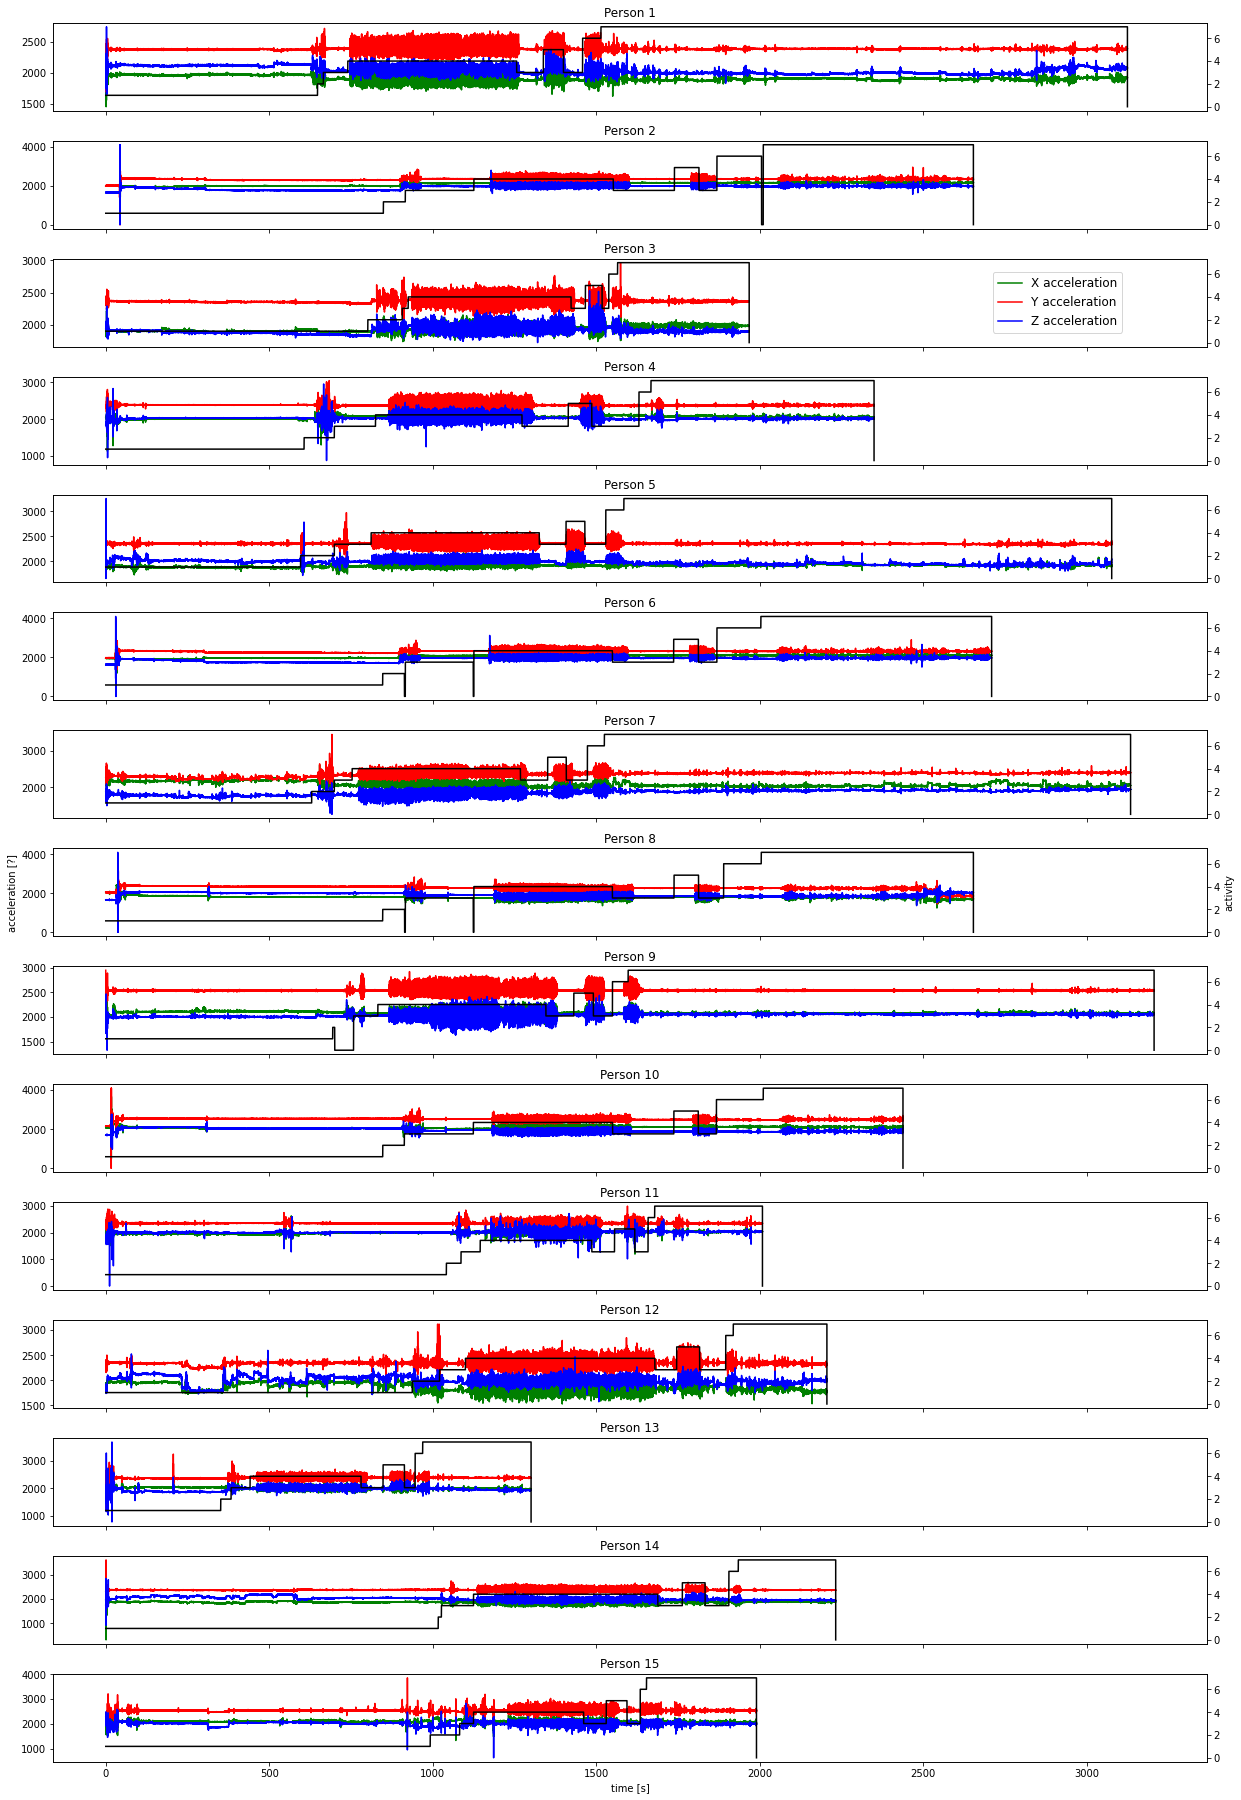

In [4]:
persons = sorted(list(dataset.person.unique()), key=lambda x:int(x))

fig, ax = plt.subplots(len(persons), sharex=True, figsize=(17,25))
fig.tight_layout(pad=2.0)

for i, person in enumerate(persons):
    df = dataset[dataset.person == person]
    time = df.index / collection_rate

    ax[i].plot(time, df.X, "g", time, df.Y, "r", time, df.Z, "b")

    ax2 = ax[i].twinx()
    ax2.plot(time, df.activity, "k")
    
    ax[i].set_title(f"Person {person}")
    if i == len(persons) - 1:
        ax[i].set_xlabel("time [s]")
    if i == len(persons) // 2:
        ax[i].set_ylabel("acceleration [?]")
        ax2.set_ylabel("activity")
_ = fig.legend(["X acceleration", "Y acceleration", "Z acceleration"], loc=(.8,.815), fontsize="large")


## Pre-processing

We can see that each subject has the same large spikes in the trace in the beginning of the sequence (first 60 seconds), perhaps related to the start-up of the experiment.

We can see that there is relatively fewer observations for activities 0 (no activity), 2 (standing up, walking and going up/down stairs), 5 (going up/down stairs) and 6 (walking and talking).
This might suggest why activities 2 and 6 were excluded from the experiments in the original paper.

In [5]:
# remove first minute from every person (setting up time, non-reliable)
preprocessed_dataset = dataset.copy()
preprocessed_dataset = preprocessed_dataset.drop(
    preprocessed_dataset[preprocessed_dataset.index < 60].index, 
    axis=0
)

# remove activities 2 and 6
preprocessed_dataset = preprocessed_dataset.drop(
    preprocessed_dataset[preprocessed_dataset.activity == 2].index, 
    axis=0
)
preprocessed_dataset = preprocessed_dataset.drop(
    preprocessed_dataset[preprocessed_dataset.activity == 6].index, 
    axis=0
)

preprocessed_dataset

,X,Y,Z,activity,person
60,1611,2019,2149,1,1
61,1597,1999,2130,1,1
62,1587,1999,2051,1,1
63,1566,1953,1993,1,1
64,1497,1966,2005,1,1
...,...,...,...,...,...
166736,2072,2545,2059,7,9
166737,2069,2547,2064,7,9
166738,2069,2542,2062,7,9
166739,2069,2543,2063,7,9


In [6]:
preprocessed_dataset.activity.unique()

array([1, 3, 4, 5, 7, 0], dtype=int64)

In [7]:
# prepare df for training
oh_activities = pd.get_dummies(preprocessed_dataset.activity, prefix="activity")

train_ready_dataset = pd.concat([preprocessed_dataset.drop(["activity", "person"], axis=1), oh_activities], axis=1)

acceleretions = ["X", "Y", "Z"]
activities = list(oh_activities.columns)

train_ready_dataset

,X,Y,Z,activity_0,activity_1,activity_3,activity_4,activity_5,activity_7
60,1611,2019,2149,0,1,0,0,0,0
61,1597,1999,2130,0,1,0,0,0,0
62,1587,1999,2051,0,1,0,0,0,0
63,1566,1953,1993,0,1,0,0,0,0
64,1497,1966,2005,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
166736,2072,2545,2059,0,0,0,0,0,1
166737,2069,2547,2064,0,0,0,0,0,1
166738,2069,2542,2062,0,0,0,0,0,1
166739,2069,2543,2063,0,0,0,0,0,1


## Building a Tensorflow model

In [8]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:
training_dataset = tf.data.Dataset.from_tensor_slices(
    tf.cast(train_ready_dataset[accelerations].values, tf.float32),
    tf.cast(train_ready_dataset[activities].values, tf.float32)
)

for features_tensor, target_tensor in training_dataset:
    print(features_tensor, target_tensor)
    break